# Training Data

This notebook creates a simulation database from an ensemble of atmospheric states. Since the purpose of this data is to verify and evaluate the QRNN and BMCI methods, it is necessary that the prior distribution on the atmospheric states can be expressed analytically. To allow for this, the ensemble is generated from the distributions fitted to the ERA Interim data for northern hemisphere, mid-latititude data from 2016. The corresponding code can be found in the `era_interim_climatology.ipynb` notebook



In [1]:
%env ARTS_INCLUDE_PATH=/home/simonpf/src/atms_retrievals:/home/simonpf/src/arts_clean/controlfiles/
%env ARTS_DATA_PATH=/home/simonpf/src/arts_xml/
%env ARTS_BUILD_PATH=/home/simonpf/build/arts/

%load_ext autoreload
%autoreload 2

import scipy as sc
import numpy as np
%matplotlib inline
import matplotlib_settings
import matplotlib.pyplot as plt

from typhon.arts.workspace import Workspace
import atms

env: ARTS_INCLUDE_PATH=/home/simonpf/src/atms_retrievals:/home/simonpf/src/arts_clean/controlfiles/
env: ARTS_DATA_PATH=/home/simonpf/src/arts_xml/
env: ARTS_BUILD_PATH=/home/simonpf/build/arts/
Loading ARTS API from: /home/simonpf/build/arts/src/libarts_api.so


## ARTS Setup

For the basic simulation, the following ATMS channels are used:

| Channel Index | Frequency          | Polarization |
|---------------|--------------------|--------------|
|             0 |    $23$ GHz        |      H       |
|            15 |    $88$ GHz        |      H       |
|            16 |    $165$ GHz       |      H       |
|            17 |    $183 \pm 7$ GHz |      H       |
|            19 |    $183 \pm 3$ GHz |      H       |

In [2]:
dataset = "summer"
suffix = ""
if not dataset == "":
    suffix = "_" + dataset

channels = [0, 15, 16, 17, 19]
ws = Workspace()
atms.setup_atmosphere(ws, dataset = dataset)
atms.setup_sensor(ws, channels)
atms.checks(ws)
ws.jacobianOff()

ARTS[53396448]: Executing /home/simonpf/src/arts_clean/controlfiles/general/general.arts
ARTS[53396448]: {
ARTS[53396448]: - verbosityInit
ARTS[53396448]: - scat_speciesSet
ARTS[53396448]: - MatrixSet
ARTS[53396448]: - Tensor4SetConstant
ARTS[53396448]: - ArrayOfStringSet
ARTS[53396448]: - Touch
ARTS[53396448]: - FlagOff
ARTS[53396448]: - MatrixSet
ARTS[53396448]: - NumericSet
ARTS[53396448]: - ArrayOfStringSet
ARTS[53396448]: - Tensor3SetConstant
ARTS[53396448]: - Tensor3SetConstant
ARTS[53396448]: - Tensor3SetConstant
ARTS[53396448]: - Tensor3SetConstant
ARTS[53396448]: - Tensor3SetConstant
ARTS[53396448]: - Tensor3SetConstant
ARTS[53396448]: - IndexSet
ARTS[53396448]: - IndexSet
ARTS[53396448]: - IndexSet
ARTS[53396448]: - IndexSet
ARTS[53396448]: - FlagOff
ARTS[53396448]: - output_file_formatSetAscii
ARTS[53396448]: - StringSet
ARTS[53396448]: - IndexSet
ARTS[53396448]: - abs_lineshapeDefine
ARTS[53396448]: - NumericSet
ARTS[53396448]: - NumericSet
ARTS[53396448]: - AgendaSet
ARTS[

## Sampling the a priori

In [3]:
dist = atms.StateDistribution(dataset = "summer")

To generate the training data, we simply sample from the a priori distribution, computed the integrated column water vapor and then simulate the corresponding brightness temperatures.

In [4]:
def sample_a_priori(ws, n_samples):
    cwv = np.zeros(n_samples)
    y   = np.zeros((n_samples, len(channels)))
    q_profiles  = np.zeros((n_samples, ws.p_grid.value.shape[0]))
    t_profiles  = np.zeros((n_samples, ws.p_grid.value.shape[0]))
    p = ws.p_grid.value

    for i in range(n_samples):
        dist.sample(ws)
        ws.yCalc()
        cwv[i] = atms.vmr2cd(ws)
        q_profiles[i,:]  = np.copy(ws.vmr_field.value[0, :, 0, 0].ravel())
        t_profiles[i, :]  = np.copy(ws.t_field.value[:, 0, 0].ravel())
        ws.sst = np.maximum(ws.t_field.value[0, 0, 0], 270.0)
        y[i]   = np.copy(ws.y.value)

        if i % 1000 == 0:
            print("progress: " + str(i))
    return y, cwv, q_profiles, t_profiles


### Training Data

For the training data $10^6$ samples from the joint a priori distribution of water vapor and temperature profiles and corresponding brightness temperatures are generated.

In [5]:
y, cwv, q_profiles, t_profiles = sample_a_priori(ws, 1000000)
np.save("data/x_train" + str(len(channels)) + suffix, y)
np.save("data/y_train" + str(len(channels)) + suffix, cwv)

progress: 0
progress: 1000
progress: 2000
progress: 3000
progress: 4000
progress: 5000
progress: 6000
progress: 7000
progress: 8000
progress: 9000
progress: 10000
progress: 11000
progress: 12000
progress: 13000
progress: 14000
progress: 15000
progress: 16000
progress: 17000
progress: 18000
progress: 19000
progress: 20000
progress: 21000
progress: 22000
progress: 23000
progress: 24000
progress: 25000
progress: 26000
progress: 27000
progress: 28000
progress: 29000
progress: 30000
progress: 31000
progress: 32000
progress: 33000
progress: 34000
progress: 35000
progress: 36000
progress: 37000
progress: 38000
progress: 39000
progress: 40000
progress: 41000
progress: 42000
progress: 43000
progress: 44000
progress: 45000
progress: 46000
progress: 47000
progress: 48000
progress: 49000
progress: 50000
progress: 51000
progress: 52000
progress: 53000
progress: 54000
progress: 55000
progress: 56000
progress: 57000
progress: 58000
progress: 59000
progress: 60000
progress: 61000
progress: 62000
progr

progress: 489000
progress: 490000
progress: 491000
progress: 492000
progress: 493000
progress: 494000
progress: 495000
progress: 496000
progress: 497000
progress: 498000
progress: 499000
progress: 500000
progress: 501000
progress: 502000
progress: 503000
progress: 504000
progress: 505000
progress: 506000
progress: 507000
progress: 508000
progress: 509000
progress: 510000
progress: 511000
progress: 512000
progress: 513000
progress: 514000
progress: 515000
progress: 516000
progress: 517000
progress: 518000
progress: 519000
progress: 520000
progress: 521000
progress: 522000
progress: 523000
progress: 524000
progress: 525000
progress: 526000
progress: 527000
progress: 528000
progress: 529000
progress: 530000
progress: 531000
progress: 532000
progress: 533000
progress: 534000
progress: 535000
progress: 536000
progress: 537000
progress: 538000
progress: 539000
progress: 540000
progress: 541000
progress: 542000
progress: 543000
progress: 544000
progress: 545000
progress: 546000
progress: 5470

progress: 971000
progress: 972000
progress: 973000
progress: 974000
progress: 975000
progress: 976000
progress: 977000
progress: 978000
progress: 979000
progress: 980000
progress: 981000
progress: 982000
progress: 983000
progress: 984000
progress: 985000
progress: 986000
progress: 987000
progress: 988000
progress: 989000
progress: 990000
progress: 991000
progress: 992000
progress: 993000
progress: 994000
progress: 995000
progress: 996000
progress: 997000
progress: 998000
progress: 999000


### Test Data

For the test data $10^5$ samples from the joint a priori distribution of water vapor and temperature profils and corresponding brightness temperatures are generated.

In [9]:
y, cwv, q_profiles, t_profiles = sample_a_priori(ws, 1000000)
np.save("data/x_train" + str(len(channels)) + suffix, y)
np.save("data/y_train" + str(len(channels)) + suffix, cwv)

## Statistics

In [1]:
q_mean = np.load("data/q_mean.npy")
t_mean = np.load("data/t_mean.npy")

f, axs = plt.subplots(1, 2)
ps = np.arange(1, 28)[::-1]

axs[0].set_ylabel("Pressure Level")
axs[0].set_xlabel("q [kg / kg]")
axs[0].set_title("Specific Humidity")
axs[0].invert_yaxis()
axs[0].plot(q_mean.ravel()[::-1], p, c = 'b')
for i in range(1000):
    ind = np.random.randint(0, q_profiles.shape[0])
    axs[0].plot(q_profiles[ind, :].ravel() / 28.0 * 18.0, p, c = 'b', alpha = 0.01)
axs[0].set_xlim([-0.001, 0.03])


axs[1].set_ylabel("Pressure Level")
axs[1].set_xlabel("t [K]")
axs[1].set_title("Temperature")
axs[1].invert_yaxis()
axs[1].plot(t_mean.ravel()[::-1], p, c = 'r')
for i in range(1000):
    ind = np.random.randint(0, t_profiles.shape[0])
    axs[1].plot(t_profiles[ind, :].ravel(), p, c = 'r', alpha = 0.01)
axs[1].set_xlim([180, 320])

plt.tight_layout()

NameError: name 'np' is not defined

## Distribution of Brightness Temperatures

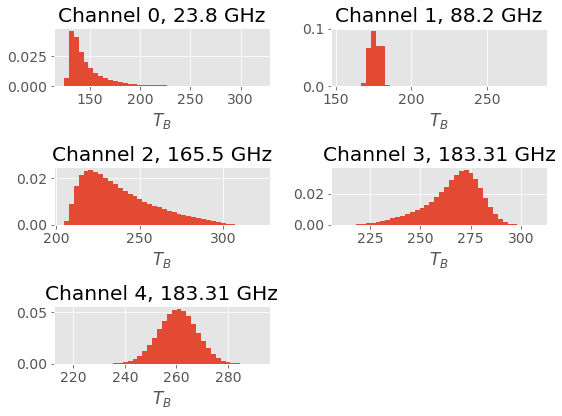

In [12]:
f, axs = plt.subplots(len(channels) // 2 + 1, 2)
for i, ax in enumerate([ax for l in axs for ax in l]):
    if i >= len(channels):
        ax.set_visible(False)
    else:
        bins = np.linspace(y[:,i].min(), y[:,i].max(), 41)
        ax.hist(y[:,i], normed=True, bins=bins)
        ax.set_xlabel("$T_B$")
        f = ws.y_f.value[i] * 1e-9
        ax.set_title("Channel " + str(i) + ", " + str(f) + " GHz")
plt.tight_layout()

## CWV Distribution

In [13]:
from netCDF4 import Dataset
rootgrp = Dataset("era_interim_mid_latitudes_2016_sst_cwv.nc")
cwv_grid = rootgrp.variables['tcwv']

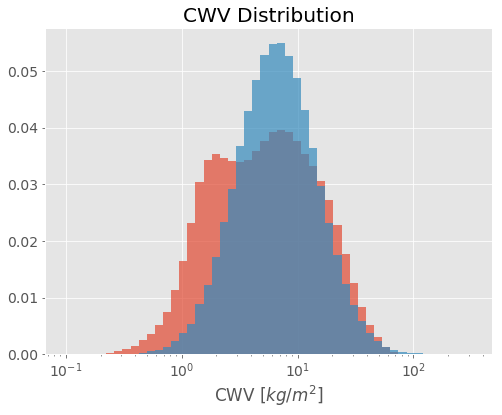

In [14]:
bins = np.logspace(-1, 2.5, 51)
plt.hist(np.asarray(cwv_grid).ravel(),
         bins = bins,
         label = "ERA Interim",
         alpha = 0.7,
         normed = True)
plt.hist(cwv,
         bins = bins,
         alpha = 0.7,
         normed = True,
         label = "Fitted")
plt.xscale("log")
plt.xlabel("CWV [$kg / m^2$]")
plt.title("CWV Distribution")